In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_2025015/2692340894.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%%time
candfiles = []
rawcat_files = []
psf_files = []
rfi_files = []

# folder = 'results/clustering_output'
folder = 'results/test1'
# folder = 'inj1/test1'
# folder = 'inj/test1'


# sbidlist = [55237, 56049, 57570, 58428]
# # sbidlist = [57570, 58479] # inj

# for sbid in sbidlist:
#     for i in range(18):
#         candfiles += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB0{sbid}/scans/*/*/{folder}/*uniq.csv')
#         rawcat_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB0{sbid}/scans/*/*/{folder}/*rawcat.csv')
#         psf_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB0{sbid}/scans/*/*/results/psf.beam*.fits')
#         rfi_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB0{sbid}/scans/*/*/{folder}/*rfi.csv')

for i in range(18):
    candfiles += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB05*/scans/*/*/{folder}/*uniq.csv')
    rawcat_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB05*/scans/*/*/{folder}/*rawcat.csv')
    psf_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB05*/scans/*/*/results/psf.beam*.fits')
    rfi_files += glob.glob(f'/DATA/SKADI_{i+1:02d}/craco/SB05*/scans/*/*/{folder}/*rfi.csv')


CPU times: user 49.7 s, sys: 1min 34s, total: 2min 23s
Wall time: 11min 18s


In [ ]:
candfiles

In [ ]:
rfi_files

In [3]:
def read_file(filename, snr=8):

    f = pd.read_csv(filename, index_col=0)
    # f = f[ (f['dm'] < 150) ]

    f = f[ f['SNR'] >= snr ]

    # remove all central ghost things
    # f = f[ ~( (f['lpix'] >= 127) & (f['mpix'] >= 127) & (f['lpix'] <= 129) & (f['lpix'] <= 129) ) ]

    return f

In [4]:
def visual_candidates(data, alpha=0.1, title='None', colorind='boxc_width'):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, dpi=100, figsize=(11, 2.5), )
    fig.tight_layout()

    ax1.scatter(data['lpix'], data['mpix'], c=data[colorind], cmap='coolwarm', alpha=alpha)
    ax2.scatter(data['total_sample_middle'], data['dm'], c=data[colorind], cmap='coolwarm', alpha=alpha)
    ax3.scatter(data['total_sample'], data['SNR'], c=data[colorind], cmap='coolwarm', alpha=alpha)
    im = ax4.scatter(data['dm'], data['SNR'], c=data[colorind], cmap='coolwarm', alpha=alpha)

    print('Number of data points:', len(data))
    print('Mean of lpix: {:.2f} Mean of mpix: {:.2f}'.format(data['lpix'].mean(), data['mpix'].mean()))
    print('Std of lpix: {:.2f} Std of mpix: {:.2f}'.format(data['lpix'].std(), data['mpix'].std()))
    print('Mean of total sample: {:.1f} Std of total sample: {:.1f}'.format(data['total_sample'].mean(), data['total_sample'].std()))
    
    ax1.set_xlim(0, 255)
    ax1.set_ylim(0, 255)
#     ax2.set_xlim(0, max(uncluster['total_sample']))
    # ax2.set_ylim(0, 40)
#     ax3.set_xlim(0, max(uncluster['total_sample']))

    ax1.set_xlabel('lpix')
    ax1.set_ylabel('mpix')
    ax2.set_xlabel('total_sample')
    ax2.set_ylabel('dm')
    ax3.set_xlabel('total_sample')
    ax3.set_ylabel('SNR')
    ax4.set_xlabel('dm')
    ax4.set_ylabel('SNR')

    ax2.set_title(title)
    fig.colorbar(im, ax=ax4)

In [26]:
%%time

m1array =  []
m2array = []
m3array = []

for ind in range(len(candfiles)):
    cand = read_file(candfiles[ind], snr=8)
    uncluster = read_file(rawcat_files[ind], snr=6)
    rfi = read_file(rfi_files[ind], snr=8)

    print(rfi_files[ind])

    for cluster_id in rfi['cluster_id']:
        
        data = uncluster[ uncluster['cluster_id'] == cluster_id ]

        if len(data) <= 2:
            continue

        if data['spatial_id'].max() <= 0:
            continue 
        
        m1 = data.groupby('spatial_id').count()['cluster_id'].max() / data.groupby('spatial_id').count()['cluster_id'].sum()
        m2 = data.groupby('spatial_id').sum()['cluster_id'].max() / (data['spatial_id'].max()+1)
        m3 = data.groupby('spatial_id').sum()['SNR'].max() / data.groupby('spatial_id').sum()['SNR'].sum()

        m1array.append(m1)
        m2array.append(m2)
        m3array.append(m3)

        lpix_mean = data[ data['spatial_id'] == data.groupby('spatial_id').sum()['SNR'].argmax() ]['lpix'].mean()
        mpix_mean = data[ data['spatial_id'] == data.groupby('spatial_id').sum()['SNR'].argmax() ]['mpix'].mean()

        # if (m1 > 0.4) & (m1 < 0.5) :
        
        if (lpix_mean<=129) & (lpix_mean>=127) & (mpix_mean<=129) & (mpix_mean>=127):
            continue

        if m3 > 0.5 :
            print(ind, cluster_id, round(lpix_mean), round(mpix_mean), len(data), m1, m2, m3)
        
m1array = np.array(m1array)
m2array = np.array(m2array)
m3array = np.array(m3array)

/DATA/SKADI_01/craco/SB055594/scans/00/20231221002731/results/test1/candidates.b00.txt.rfi.csv
0 392.0 166 126 13932 0.6691788687912719 4727.834411384218 0.6933458539253506
0 397.0 172 128 16384 0.70904541015625 8162.741592920354 0.7148569665568729
0 598.0 175 127 16384 0.7740478515625 12875.782682512734 0.7774812182904145
0 657.0 173 128 16384 0.7158203125 14402.422429906543 0.7230331293245666
0 706.0 169 127 16384 0.7760009765625 12032.28418230563 0.8035239790521891
0 751.0 172 126 16384 0.71942138671875 15262.13275862069 0.7264089206305039
/DATA/SKADI_01/craco/SB055594/scans/00/20231221002731/results/test1/candidates.b18.txt.rfi.csv
1 38.0 164 112 1672 0.7093301435406698 5007.555555555556 0.7338508794718585
1 39.0 164 112 2180 0.6995412844036697 11895.0 0.715334852526649
1 40.0 164 112 3736 0.6911134903640257 11475.555555555555 0.715293411376257
1 42.0 164 112 2583 0.6066589237320945 1994.3636363636363 0.6148555823266341
1 62.0 164 112 4335 0.6145328719723183 1876.909090909091 0.653

/tmp/ipykernel_2025015/3403981670.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.read_csv(filename, index_col=0)


/DATA/SKADI_02/craco/SB058867/scans/00/20240209000250/results/test1/candidates.b19.txt.rfi.csv
17929 712.0 4 209 248 0.9395161290322581 27649.333333333332 0.9443566042325469
17929 1605.0 65 176 272 0.5735294117647058 12519.0 0.5882186188910308
17929 1887.0 22 196 3527 0.6365182874964559 63228.58208955224 0.6450424766146203
17929 2158.0 29 194 4438 0.48963497070752593 56498.0 0.5024959685900582
17929 2257.0 24 193 826 0.9951573849878934 463813.5 0.9954722699635934
17929 2369.0 249 177 3989 0.7229882175983956 139432.57142857142 0.7316420454326358
17929 2784.0 26 184 3293 0.8566656544184634 196341.6 0.8613645165956613
17929 4338.0 253 96 250 0.704 109069.71428571429 0.713975828943291
17929 4600.0 97 230 1593 0.5072190834902699 80800.0 0.5132088938232932
17929 4685.0 60 172 2283 0.5405168637757337 99677.41379310345 0.5468185204602521
17929 4908.0 228 18 625 0.6704 171371.0 0.679642803840605
17929 7776.0 2 62 438 0.6735159817351598 127440.0 0.6832171994817747
17929 7820.0 147 218 765 0.7163

(0.0, 1.0)

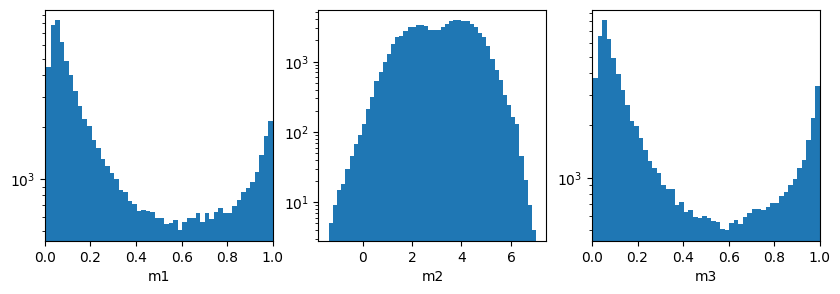

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), dpi=100)

ax1.hist(m1array, log=True, bins=50)
ax2.hist(np.log10(m2array[m2array!=0]), log=True, bins=50)
ax3.hist(m3array, log=True, bins=50)

ax1.set_xlabel('m1')
ax2.set_xlabel('m2')
ax3.set_xlabel('m3')

ax1.set_xlim(0, 1)
ax3.set_xlim(0, 1)

Number of data points: 213
Mean of lpix: 40.13 Mean of mpix: 49.87
Std of lpix: 20.32 Std of mpix: 22.91
Mean of total sample: 543.1 Std of total sample: 7.0
0.9624413145539906 68.33333333333333 0.966805536890203
8.8
/DATA/SKADI_01/craco/SB055853/scans/00/20231224170618/results/test1/candidates.b15.txt.uniq.csv


,SNR,lpix,mpix,boxc_width,time,dm,iblk,rawsn,total_sample,obstime_sec,mjd,dm_pccm3,ra_deg,dec_deg,total_sample_middle,cluster_id,spatial_id
580,8.8,38,46,7,33,17,2,275,545,7.5341,60302.714844,79.069,97.80653,22.57844,534.547515,2,0.0


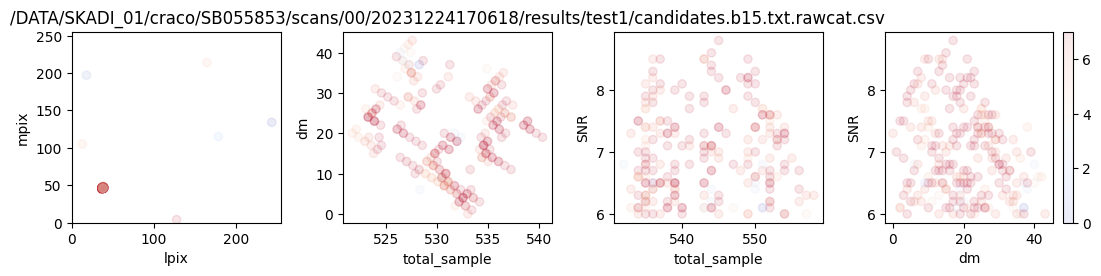

In [138]:
ind, cluster_id = 436, 2

cand = read_file(candfiles[ind], snr=8)
uncluster = read_file(rawcat_files[ind], snr=6)
rfi = read_file(rfi_files[ind], snr=8)
data = uncluster[ uncluster['cluster_id'] == cluster_id ]
# data = uncluster[ (uncluster['cluster_id'] == cluster_id) & (uncluster['spatial_id'] == 0) ]

m1 = data.groupby('spatial_id').count()['cluster_id'].max() / data.groupby('spatial_id').count()['cluster_id'].sum()
m2 = data.groupby('spatial_id').sum()['cluster_id'].max() / data['spatial_id'].max()
m3 = data.groupby('spatial_id').sum()['SNR'].max() / data.groupby('spatial_id').sum()['SNR'].sum()

# visual_candidates(data=data, title=rawcat_files[ind], colorind='spatial_id')
visual_candidates(data=data, title=rawcat_files[ind], alpha=0.1)

print(m1, m2, m3)
print(data.SNR.max())
print(candfiles[ind])
data[ data.SNR == data.SNR.max() ]
# data[ data.spatial_id == 0 ]
# data

Number of data points: 281
Mean of lpix: 126.65 Mean of mpix: 111.10
Std of lpix: 19.37 Std of mpix: 2.56
Mean of total sample: 34575.8 Std of total sample: 1.1
0.9537366548042705 26666.0 0.9589753953417873
9.4
/DATA/SKADI_03/craco/SB056814/scans/00/20240106044149/results/test1/candidates.b15.txt.uniq.csv


,SNR,lpix,mpix,boxc_width,time,dm,iblk,rawsn,total_sample,obstime_sec,mjd,dm_pccm3,ra_deg,dec_deg,total_sample_middle,cluster_id,spatial_id
62236,9.4,131,111,7,15,0,135,268,34575,477.9648,60315.199219,0.0,284.98883,4.21102,34575.0,398,0.0


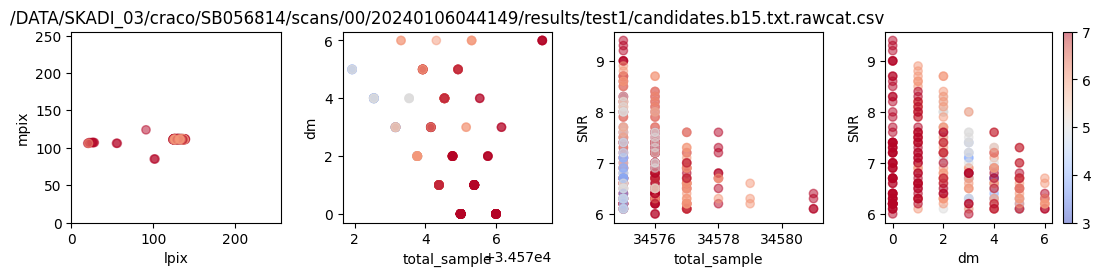

In [132]:
ind, cluster_id = 25278, 398

cand = read_file(candfiles[ind], snr=8)
uncluster = read_file(rawcat_files[ind], snr=6)
rfi = read_file(rfi_files[ind], snr=8)
data = uncluster[ uncluster['cluster_id'] == cluster_id ]
# data = uncluster[ (uncluster['cluster_id'] == cluster_id) & (uncluster['spatial_id'] == 367) ]

m1 = data.groupby('spatial_id').count()['cluster_id'].max() / data.groupby('spatial_id').count()['cluster_id'].sum()
m2 = data.groupby('spatial_id').sum()['cluster_id'].max() / data['spatial_id'].max()
m3 = data.groupby('spatial_id').sum()['SNR'].max() / data.groupby('spatial_id').sum()['SNR'].sum()

# visual_candidates(data=data, title=rawcat_files[ind], colorind='SNR', alpha=0.5)
visual_candidates(data=data, title=rawcat_files[ind], alpha=0.5)

print(m1, m2, m3)
print(data.SNR.max())
print(candfiles[ind])
data[ data.SNR == data.SNR.max() ]
# data[ data.spatial_id == 367 ]
# data

In [112]:
uncluster[ (uncluster['lpix'] == 94) & (uncluster['total_sample'] >= 54809) & (uncluster['total_sample'] <= 54851) ]

,SNR,lpix,mpix,boxc_width,time,dm,iblk,rawsn,total_sample,obstime_sec,mjd,dm_pccm3,ra_deg,dec_deg,total_sample_middle,cluster_id,spatial_id
1611163,10.0,94,135,0,46,0,214,285,54830,757.9699,60316.285156,0.000,312.15009,-15.92213,54830.000000,676,369.0
1611164,8.2,94,150,1,47,0,214,235,54831,757.9838,60316.285156,0.000,312.15005,-15.85766,54831.000000,676,364.0
1611165,6.7,94,166,0,46,0,214,191,54830,757.9699,60316.285156,0.000,312.15005,-15.78888,54830.000000,676,359.0
1611166,6.2,94,236,0,46,0,214,176,54830,757.9699,60316.285156,0.000,312.15021,-15.48776,54830.000000,676,366.0
1611167,106.5,94,52,1,47,0,214,3039,54831,757.9838,60316.285156,0.000,312.15057,-16.27859,54831.000000,676,367.0
1611168,11.2,94,68,1,47,0,214,319,54831,757.9838,60316.285156,0.000,312.15045,-16.20991,54831.000000,676,370.0
1611169,13.9,94,82,0,46,0,214,396,54830,757.9699,60316.285156,0.000,312.15036,-16.14980,54830.000000,676,355.0
1611170,6.1,94,119,0,46,0,214,173,54830,757.9699,60316.285156,0.000,312.15015,-15.99088,54830.000000,676,371.0
1612939,8.6,94,135,4,47,1,214,245,54831,757.9838,60316.285156,4.651,312.15009,-15.92213,54830.385163,676,369.0
1612940,10.3,94,149,1,47,1,214,293,54831,757.9838,60316.285156,4.651,312.15005,-15.86196,54830.385163,676,364.0


In [ ]:
rfi

In [ ]:
spatial_id = 0

visual_candidates(data=data[ data['spatial_id'] == spatial_id ], title=rawcat_files[ind])

In [ ]:
spatial_id = 1

visual_candidates(data=data[ data['spatial_id'] == spatial_id ], title=rawcat_files[ind])

In [ ]:
spatial_id = 2

visual_candidates(data=data[ data['spatial_id'] == spatial_id ], title=rawcat_files[ind])

In [20]:
data[ data['spatial_id'] == data.groupby('spatial_id').sum()['SNR'].argmax() ]['lpix'].mean()

127.92620751341681

In [17]:
data.groupby('spatial_id').sum()['SNR'].argmax()

0

In [ ]:
ind = 0
cluster_id = 74

cand = read_file(candfiles[ind], snr=8)
uncluster = read_file(rawcat_files[ind], snr=6)
rfi = read_file(rfi_files[ind], snr=8)
data = uncluster[ uncluster['cluster_id'] == cluster_id ]

m1 = data.groupby('spatial_id').count()['cluster_id'].max() / data.groupby('spatial_id').count()['cluster_id'].sum()
m2 = data.groupby('spatial_id').sum()['cluster_id'].max() / data['spatial_id'].max()
m3 = data.groupby('spatial_id').sum()['SNR'].max() / data.groupby('spatial_id').sum()['SNR'].sum()

# visual_candidates(data=data, title=rawcat_files[ind], colorind='spatial_id', alpha=0.5)
visual_candidates(data=data, title=rawcat_files[ind], alpha=0.5)

print(m1, m2, m3)
print(data.SNR.max())

data

In [ ]:
%%time

m1array =  []
m2array = []
m3array = []

for ind in range(len(candfiles)):
    cand = read_file(candfiles[ind], snr=8)
    uncluster = read_file(rawcat_files[ind], snr=6)
    rfi = read_file(rfi_files[ind], snr=8)

    print(rfi_files[ind])

    for cluster_id in cand['cluster_id']:
        
        data = uncluster[ uncluster['cluster_id'] == cluster_id ]

        if len(data) <= 2:
            continue

        # if data['spatial_id'].max() <= 0:
        #     continue 
        
        m1 = data.groupby('spatial_id').count()['cluster_id'].max() / data.groupby('spatial_id').count()['cluster_id'].sum()
        m2 = data.groupby('spatial_id').sum()['cluster_id'].max() / data['spatial_id'].max()
        m3 = data.groupby('spatial_id').sum()['SNR'].max() / data.groupby('spatial_id').sum()['SNR'].sum()

        m1array.append(m1)
        m2array.append(m2)
        m3array.append(m3)

        if m2 > 400 :
            print(ind, cluster_id, len(data), m1, m2, m3)
        if len(data) > 1000:
            print(ind, cluster_id, len(data), m1, m2, m3)

m1array = np.array(m1array)
m2array = np.array(m2array)
m3array = np.array(m3array)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), dpi=100)

ax1.hist(m1array, log=True, bins=50)
# ax2.hist(m2array, log=True, bins=50)
ax3.hist(m3array, log=True, bins=50)